In [1]:
# in order to install the required packages for the snn conversion, 
# you need the following packages
# furthemore you must have installed miniconda or anaconda
# and activated a virtual environment to execute the following commands

# %conda install akida
# %conda install cnn2snn
# %conda install akida-models

In [2]:
# yolo
# imagenet
# cnn
# wider

model_name = "cnn"
use_gray = True

In [3]:
import tensorflow as tf
import utils

tf.random.set_seed(1)

2023-04-04 10:46:35.211448: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 10:46:35.337133: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-04 10:46:35.369013: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-04 10:46:35.963368: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

2023-04-04 10:46:37.351403: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 10:46:38.606900: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22826 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:e6:00.0, compute capability: 7.5
2023-04-04 10:46:38.607776: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9618 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:d5:00.0, compute capability: 7.5


,faces/bbox,faces/blur,faces/expression,faces/illumination,faces/invalid,faces/occlusion,faces/pose,image,image/filename
0,,,,,,,,,13--Interview/13_Interview_Interview_On_Location_13_702.jpg
1,,,,,,,,,16--Award_Ceremony/16_Award_Ceremony_Awards_Ceremony_16_129.jpg
2,,,,,,,,,9--Press_Conference/9_Press_Conference_Press_Conference_9_809.jpg
3,,,,,,,,,52--Photographers/52_Photographers_photographertakingphoto_52_533.jpg
4,,,,,,,,,51--Dresses/51_Dresses_wearingdress_51_319.jpg
5,,,,,,,,,23--Shoppers/23_Shoppers_Shoppers_23_714.jpg
6,,,,,,,,,25--Soldier_Patrol/25_Soldier_Patrol_Soldier_Patrol_25_230.jpg
7,,,,,,,,,53--Raid/53_Raid_policeraid_53_734.jpg
8,,,,,,,,,53--Raid/53_Raid_policeraid_53_542.jpg
9,,,,,,,,,28--Sports_Fan/28_Sports_Fan_Sports_Fan_28_493.jpg

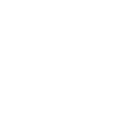
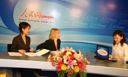
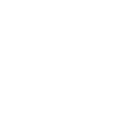
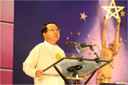
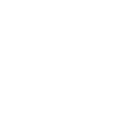
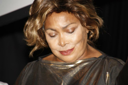
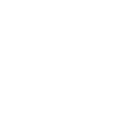
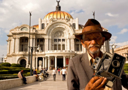
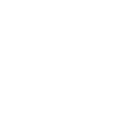
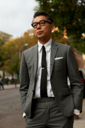
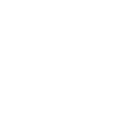
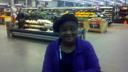
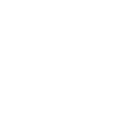
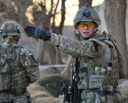
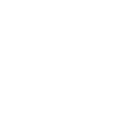
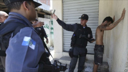
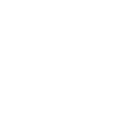
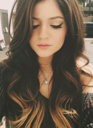
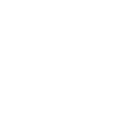
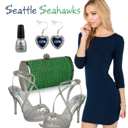

Empty StyledDataFrame
Columns: []
Index: []

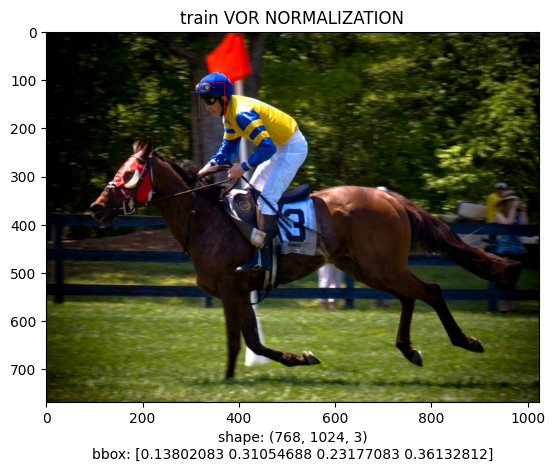

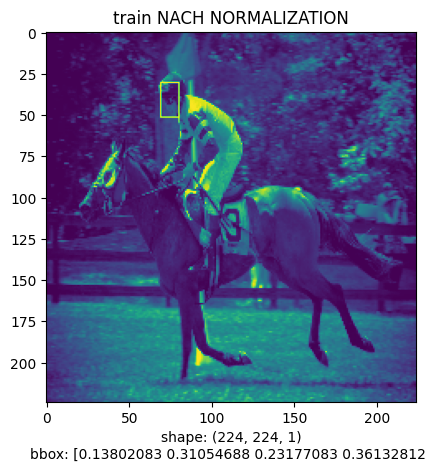

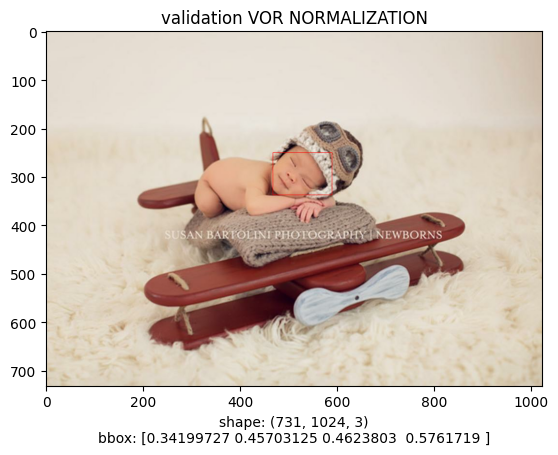

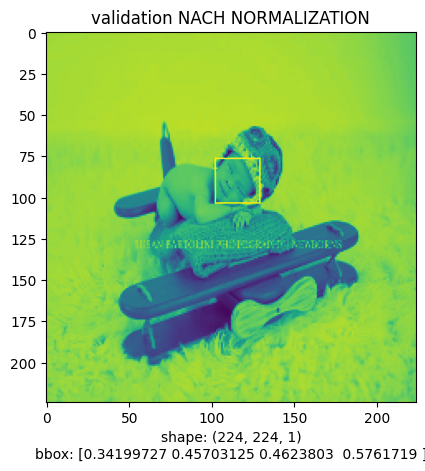

In [4]:
ds_train, ds_train_info = utils.getDataset('train', only_one=True, use_gray=True)
ds_test, ds_test_info = utils.getDataset('test', only_one=True, use_gray=True)
ds_eval, ds_eval_info = utils.getDataset('validation', only_one=True, use_gray=True)

In [5]:
from tensorflow.keras.models import load_model
from akida_models import yolo_base, yolo_widerface_pretrained
from tensorflow.keras.utils import get_file
from tensorflow.keras.layers import Dense, Flatten, Conv2D, ReLU, BatchNormalization
from tensorflow.keras import Sequential

In [6]:
model : Sequential = Sequential()

if(model_name == "yolo"):
    yolo_model = yolo_base()
    
    print(yolo_model.summary())
    
    model.add(yolo_model)
    
elif model_name == "wider":
    
    model, anchors = yolo_widerface_pretrained()
    
    print(model.predict(ds_eval))
    
    #utils.predict(model=model, model_name=model_name, ds)
    
elif(model_name == "imagenet"):
    
    model_file = get_file(
        "akidanet_imagenet_224_alpha_50.h5",
        "http://data.brainchip.com/models/akidanet/akidanet_imagenet_224_alpha_50.h5",
        cache_subdir='models/akidanet_imagenet')
    model.add(load_model(model_file))

elif(model_name == "cnn"):
    
    input_shapes = [
    (224,224,1 if use_gray else 3),
    (224,224,16),
    (112,112,32),
    (56,56,64),
    (28,28,128),
    (14,14,1024),
    (14,14,512),
    (7,7,256),
    (7,7,128),
    (7,7,64),
    (7,7,32),
    (4,)]

    for input_shape in input_shapes:
    
        model.add(Conv2D(2,7, input_shape=input_shape)) 
        model.add(BatchNormalization(input_shape=input_shape)) 
        model.add(ReLU(input_shape=input_shape))

model.add(Flatten())
model.add(Dense(4, activation='relu'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 218, 2)       100       
                                                                 
 batch_normalization (BatchN  (None, 218, 218, 2)      8         
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 218, 218, 2)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 212, 212, 2)       198       
                                                                 
 batch_normalization_1 (Batc  (None, 212, 212, 2)      8         
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 212, 212, 2)       0

In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"), 
              metrics=['accuracy'])#[tf.keras.metrics.MeanIoU(num_classes=1)])


callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)]

In [8]:
model.fit(
    x=ds_train,
    epochs=40,
    validation_data=ds_test,
    callbacks=callbacks
)

Epoch 1/40


2023-04-04 10:47:14.622199: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


37/37 [==============================] - 15s 277ms/step - loss: 0.2242 - accuracy: 0.0205
Epoch 2/40
37/37 [==============================] - 6s 163ms/step - loss: 0.2151 - accuracy: 0.0000e+00
Epoch 3/40
37/37 [==============================] - 6s 163ms/step - loss: 0.2151 - accuracy: 0.0000e+00
Epoch 4/40
37/37 [==============================] - 6s 163ms/step - loss: 0.2151 - accuracy: 0.0000e+00
Epoch 5/40
37/37 [==============================] - 6s 164ms/step - loss: 0.2151 - accuracy: 0.0000e+00
Epoch 6/40
37/37 [==============================] - 6s 164ms/step - loss: 0.2151 - accuracy: 0.0000e+00
Epoch 7/40
37/37 [==============================] - 6s 164ms/step - loss: 0.2151 - accuracy: 0.0000e+00


In [9]:
results = model.evaluate(
  ds_eval
)

print("test loss, test acc:", results)

if(model_name == "imagenet"):
  model.save("models/imagenet_model")
elif(model_name == "yolo"):
  model.save("models/yolo_model")
elif(model_name == "cnn"):
  model.save("models/cnn_model")

9/9 [==============================] - 2s 185ms/step - loss: 0.2124 - accuracy: 0.0036
test loss, test acc: [0.2124258577823639, 0.003565062303096056]


INFO:tensorflow:Assets written to: models/cnn_model/assets


INFO:tensorflow:Assets written to: models/cnn_model/assets


In [10]:
if(model_name == "imagenet"):
  model = tf.keras.models.load_model("models/imagenet_model")
elif(model_name == "yolo"):
  model = tf.keras.models.load_model("models/yolo_model")
elif(model_name == "cnn"):
  model = tf.keras.models.load_model("models/cnn_model")

In [11]:
utils.predict(model=model, model_name=model_name, ds=ds_train)

4/4 [==============================] - 1s 9ms/step


Groundtruth: [[0.31366906 0.296875   0.60431653 0.4296875 ]
 [0.167576   0.39648438 0.40530008 0.6044922 ]
 [0.25941423 0.31445312 0.64783823 0.73828125]
 [0.4589443  0.19140625 0.51466274 0.22167969]
 [0.17130308 0.4033203  0.21815519 0.4326172 ]]




Predicted: [[[0. 0. 0. 0.]]

 [[0. 0. 0. 0.]]

 [[0. 0. 0. 0.]]

 [[0. 0. 0. 0.]]

 [[0. 0. 0. 0.]]]




[[[[0.3926977 ]
   [0.38737607]
   [0.39661887]
   ...
   [0.4309722 ]
   [0.42312983]
   [0.4191655 ]]

  [[0.3915679 ]
   [0.38624626]
   [0.39548907]
   ...
   [0.427051  ]
   [0.41920868]
   [0.41397247]]

  [[0.39258528]
   [0.38726366]
   [0.3954999 ]
   ...
   [0.42417872]
   [0.4177367 ]
   [0.4124152 ]]

  ...

  [[0.8537534 ]
   [0.8537534 ]
   [0.8527467 ]
   ...
   [0.8476816 ]
   [0.8476816 ]
   [0.8476816 ]]

  [[0.8537534 ]
   [0.8537534 ]
   [0.8537534 ]
   ...
   [0.8476816 ]
   [0.8476816 ]
   [0.8476816 ]]

  [[0.8537534 ]
   [0.8537534 ]
   [0.8537534 ]
   ...
  

InvalidArgumentError: {{function_node __wrapped__DrawBoundingBoxesV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} The rank of the boxes tensor should be 3 [Op:DrawBoundingBoxesV2]

4/4 [==============================] - 0s 14ms/step


Groundtruth: [[[0.04116638 0.33691406 0.14236706 0.45996094]]

 [[0.14641288 0.6699219  0.25475842 0.72265625]]

 [[0.39908853 0.43359375 0.6295573  0.71191406]]

 [[0.5933852  0.47265625 0.63878083 0.5644531 ]]

 [[0.2474026  0.140625   0.6707792  0.6542969 ]]

 [[0.5625     0.46289062 0.6640625  0.59375   ]]

 [[0.24390244 0.09960938 0.33231708 0.18945312]]

 [[0.13689604 0.4091797  0.22474378 0.49804688]]

 [[0.21081577 0.38867188 0.42163154 0.57128906]]

 [[0.19722651 0.38085938 0.59938365 0.72753906]]

 [[0.3195435  0.49609375 0.48787448 0.58984375]]

 [[0.01041667 0.20898438 0.07552084 0.26757812]]

 [[0.36197916 0.43554688 0.6171875  0.5878906 ]]

 [[0.325      0.4658203  0.4390625  0.51171875]]

 [[0.12298682 0.61328125 0.48901904 0.82421875]]

 [[0.6502636  0.19921875 0.7012302  0.21875   ]]

 [[0.27818447 0.5078125  0.4275256  0.578125  ]]

 [[0.49323308 0.38671875 0.5593985  0.44921875]]

 [[0.19503546 0.20410156 0.675531

2023-03-24 08:45:32.734959: W tensorflow/core/kernels/image/draw_bounding_box_op.cc:150] Bounding box (144,260,168,272) is completely outside the image and will not be drawn.
2023-03-24 08:45:32.734994: W tensorflow/core/kernels/image/draw_bounding_box_op.cc:150] Bounding box (243,216,253,237) is completely outside the image and will not be drawn.
2023-03-24 08:45:32.735000: W tensorflow/core/kernels/image/draw_bounding_box_op.cc:150] Bounding box (236,214,259,243) is completely outside the image and will not be drawn.
2023-03-24 08:45:32.735028: W tensorflow/core/kernels/image/draw_bounding_box_op.cc:150] Bounding box (138,248,220,295) is completely outside the image and will not be drawn.
2023-03-24 08:45:32.735032: W tensorflow/core/kernels/image/draw_bounding_box_op.cc:150] Bounding box (256,155,267,160) is completely outside the image and will not be drawn.
2023-03-24 08:45:32.735035: W tensorflow/core/kernels/image/draw_bounding_box_op.cc:150] Bounding box (173,224,206,240) is co

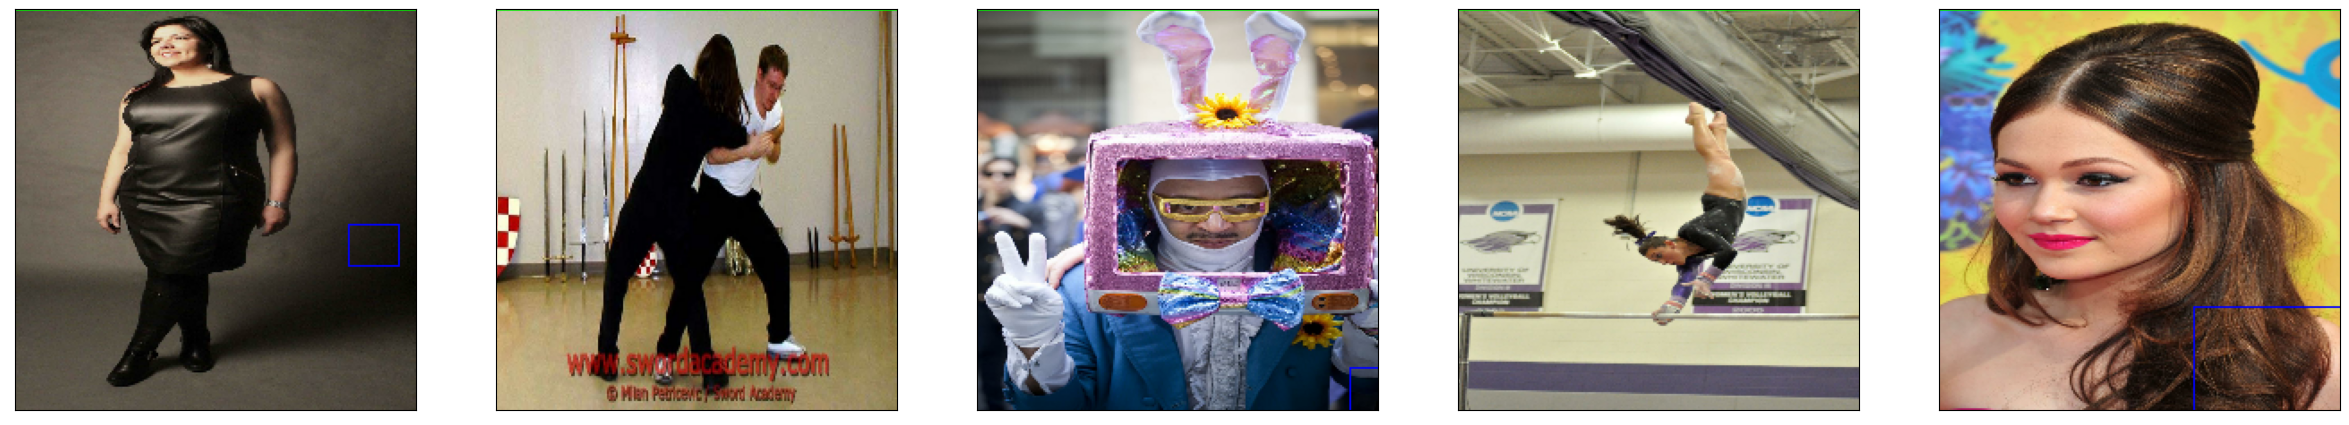

In [ ]:
utils.predict(model=model, model_name=model_name, ds=ds_eval)